In [1]:
from utils.reader import CryptoCsvReader
from utils.plotter import Plotter

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import mfn

csv_files = [
    ('bitcoin_trust.csv', 'IBTC'),
    ('ibovespa.csv', 'IBOVESPA'),
    ('imab.csv', 'IMA-B'),
    ('scbtg.csv', 'SCBTG'),
    ('sp500.csv', 'S&P 500')
]

# Plots do paper

IBTC


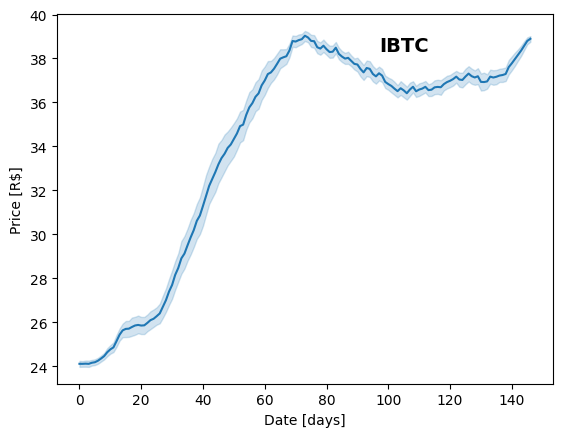

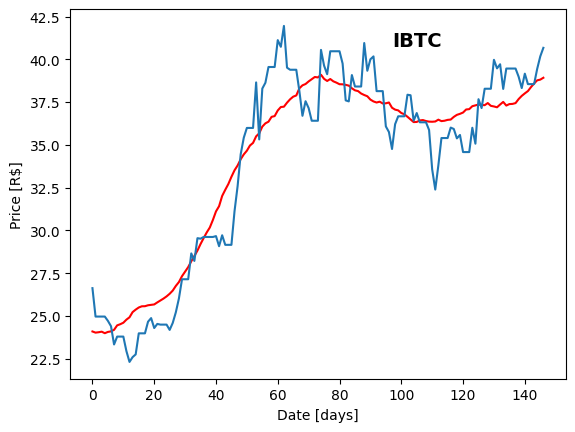

IBOVESPA


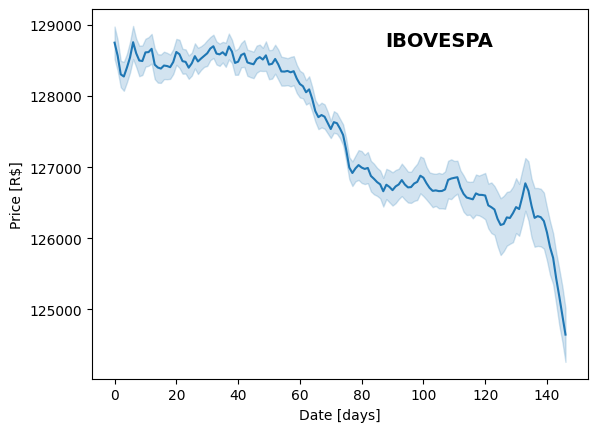

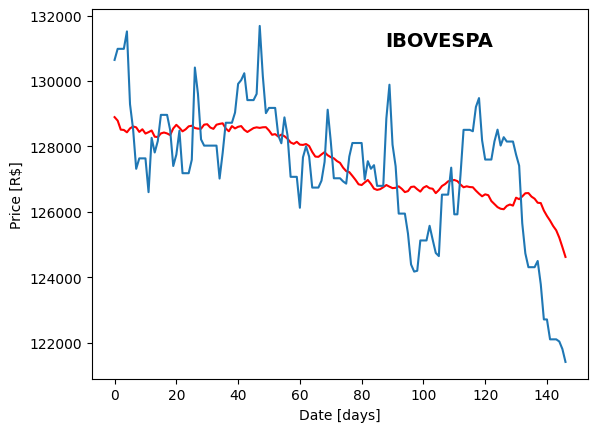

IMA-B


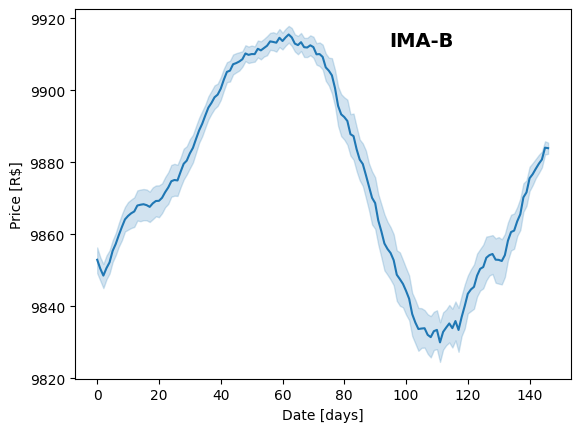

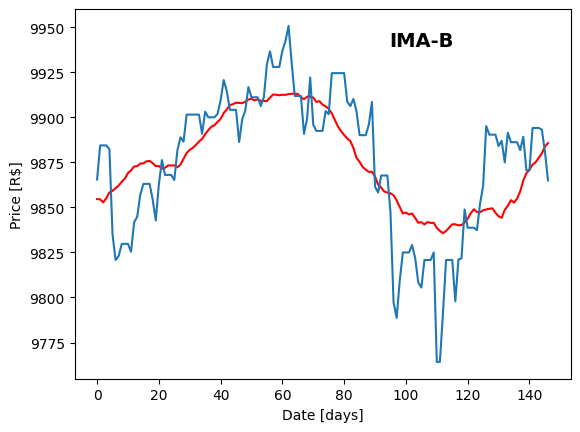

SCBTG


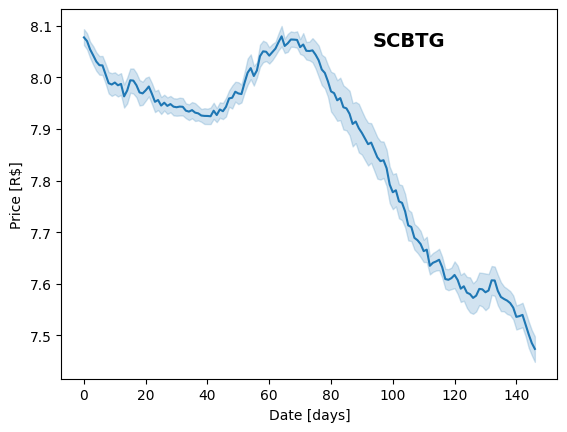

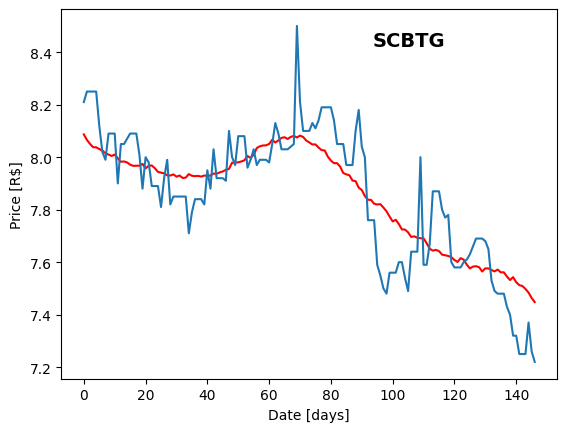

S&P 500


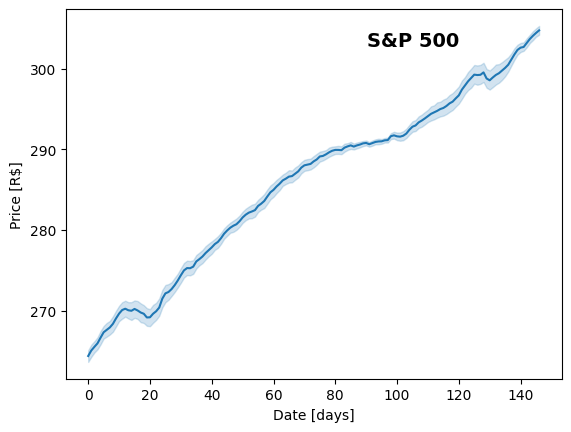

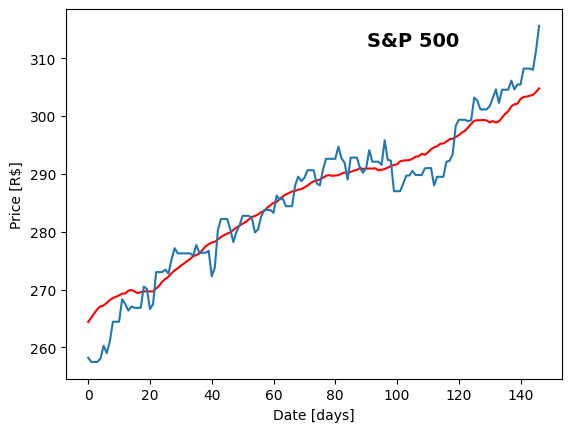

In [5]:
#Plotting lbb and confidence interval

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mfn.bootstrap import lbb
from mfn.entropy import MFN
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy import stats as st
from utils.plotter import calculate_statistics

statistics = []

for path, name in csv_files:
    reader = CryptoCsvReader(f'data/{path}')
    data  = reader.read()
    plotter = Plotter(data, name)
    plotter.plot_lbb_mean_with_ci()
    plotter.plot_lbb_mean()
    value_dict = MFN(
       data,
       b=147,
       B=.147,
       size=147,
       dx=3
    )
    mfn_res = value_dict
    fim = np.mean(mfn_res['fisher information'])
    miee = np.mean(mfn_res['miee'])
    pe = np.mean(mfn_res['permutation entropy'])
    mean = np.mean(data)
    median = np.median(data)
    std_dev = np.std(data)
    kurtosis = st.kurtosis(data)
    skewness = st.skew(data)

    stats = pd.Series({
        'Mean': mean,
        'Median': median,
        'Standard Deviation': std_dev,
        'Kurtosis': kurtosis,
        'Skewness': skewness,
        'Fishers Information': fim,
        'MIEE': miee,
        'Permutation Entropy': pe
    })
    stats.name = name
    statistics.append(stats)

#Convert to DataFrame
stats_df = pd.DataFrame(statistics).T

#Rename index to match desired output
stats_df.to_excel('statistics_summary.xlsx', index=True)

#Save to CSV
stats_df.to_csv('statistics_summary.csv')



bitcoin_trust.csv IBTC


/tmp/ipykernel_1769702/2095001144.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Category', y='Value', data=df, palette='pastel')


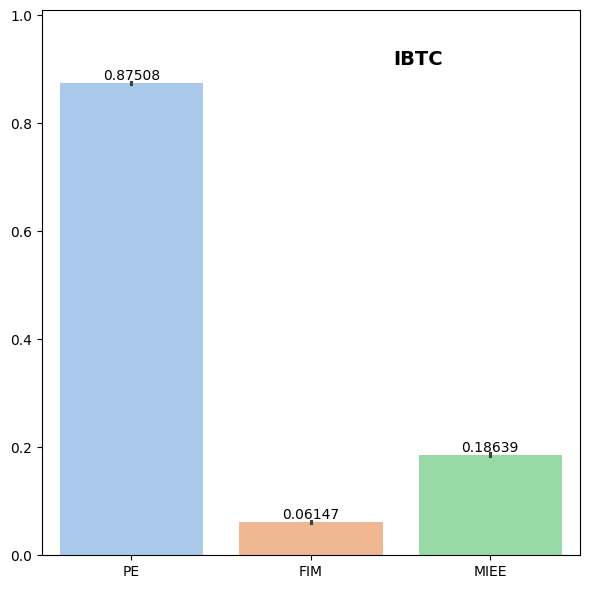

ibovespa.csv IBOVESPA


/tmp/ipykernel_1769702/2095001144.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Category', y='Value', data=df, palette='pastel')


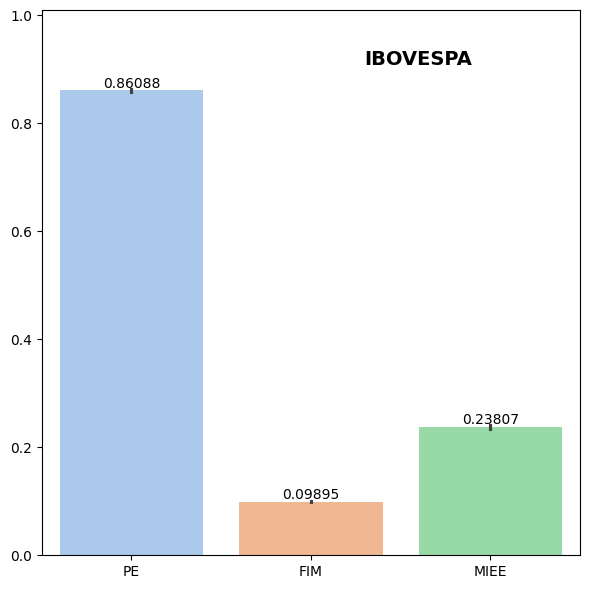

imab.csv IMA-B


/tmp/ipykernel_1769702/2095001144.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Category', y='Value', data=df, palette='pastel')


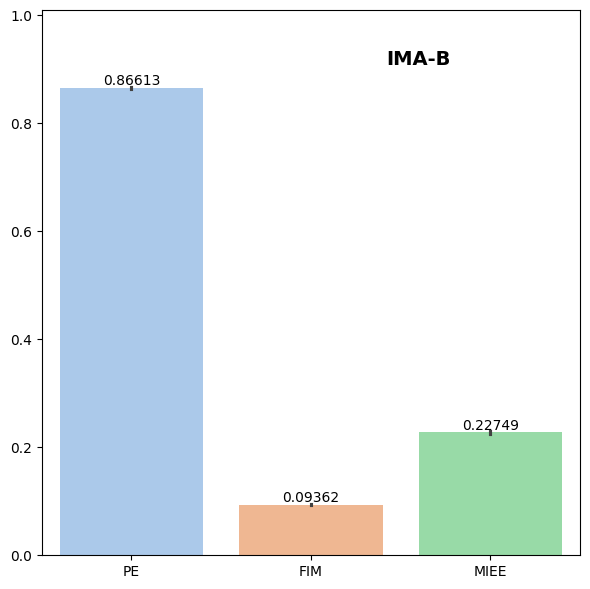

scbtg.csv SCBTG


/tmp/ipykernel_1769702/2095001144.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Category', y='Value', data=df, palette='pastel')


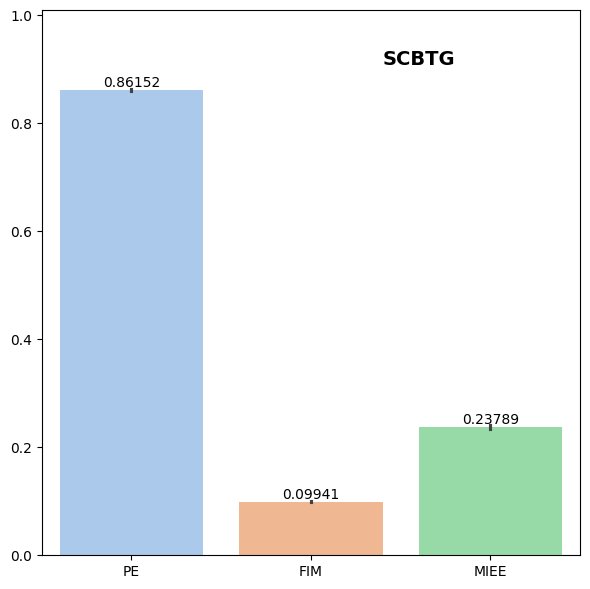

sp500.csv S&P 500


/tmp/ipykernel_1769702/2095001144.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Category', y='Value', data=df, palette='pastel')


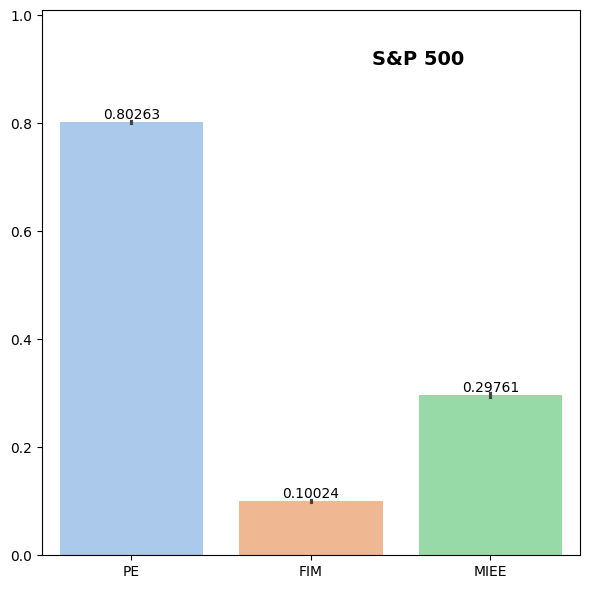

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from utils.plotter import calculate_statistics

statistics = []
for path, name in csv_files:
    print(path, name)
    reader = CryptoCsvReader(f'data/{path}')
    data  = reader.read()
    #mfn_res = plotter.plot_mfn() #this plotter function went out of whack so I did the raw implementation
    value_dict = MFN(
            data,
            b=147,
            B=.147,
            size=147,
            dx=3
        )

    f, ax = plt.subplots(figsize=(6, 6))
    value_df = pd.DataFrame(value_dict).reset_index()
    value_df = value_df.melt(id_vars='index', value_vars=value_df.columns[1:])
    # Sample DataFrame
    data = {
        'Category': value_df['variable'],
        'Value': value_df['value']
    }
    df = pd.DataFrame(data)

    bar_plot = sns.barplot(x='Category', y='Value', data=df, palette='pastel')

# Add value labels on top of each bar
    for p in bar_plot.patches:
        bar_plot.annotate(f'{round(p.get_height(),5)}', 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha='center', va='bottom')

# Set titles and labels
    ax.text(
    x=0.7,  # Horizontal position in axes coordinates (0 to 1)
    y=0.9,  # Vertical position in axes coordinates (0 to 1)
    s=f"{name}",
    fontsize=14,
    weight='bold',
    ha='center',
    transform=ax.transAxes
    )
    
    plt.title('')
    
    plt.xlabel('')
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['PE','FIM','MIEE'])

    plt.ylabel('')
    plt.ylim(0,1.0105)
    
    ax.grid(False)
    f.tight_layout()
    plt.savefig(f'imgs/{name}_mfn.png')

# Show the plot
    plt.show()

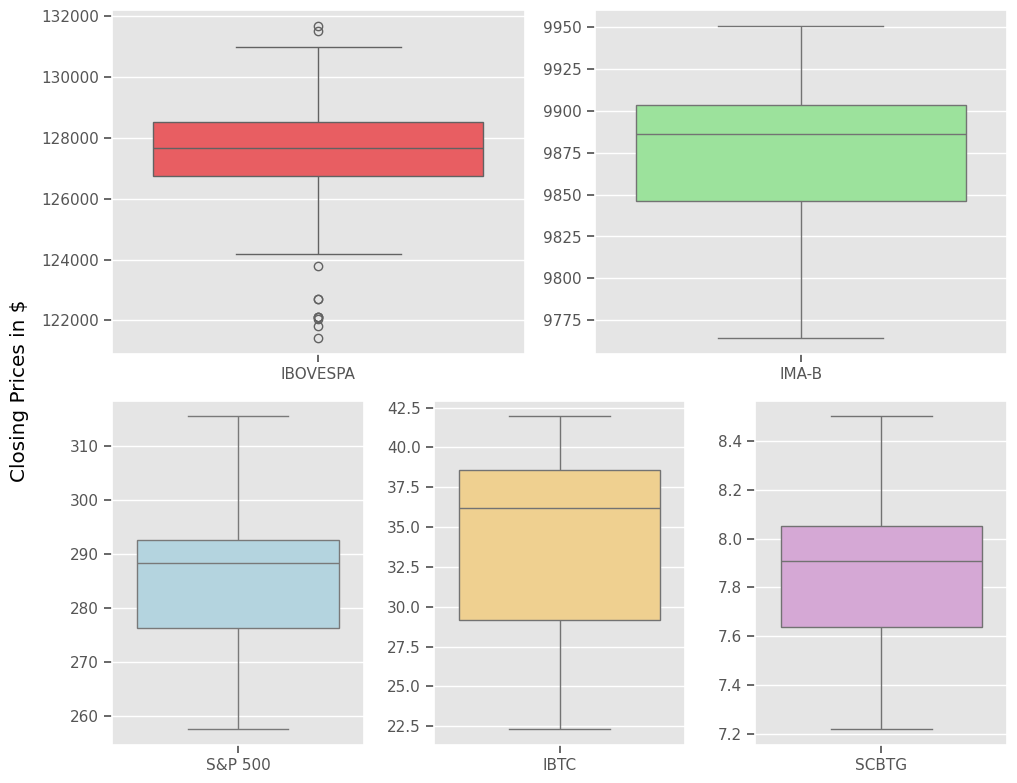

In [7]:
from matplotlib import gridspec
from matplotlib import pyplot as plt
#sns.set_style("white")
plt.style.use('ggplot')  
sns.set_context("notebook") 
sns.set_palette("deep") 
#sns.set_style("darkgrid") 
time_series_list = []
last_length = None 

for path, name in csv_files:
    reader = CryptoCsvReader(f'data/{path}')
    data = reader.read()
    
    if last_length is not None and len(data) != last_length:
        raise Exception('lenghts not match')
    
    last_length = len(data)
    
    time_series_list.append((data, name))

time_series = [x[0] for x in time_series_list]
labels = [x[1] for x in time_series_list]

data = {
    'data': time_series,
    'label': labels  # Corresponding labels
}

# Create a DataFrame
df = pd.DataFrame(data)
#print(data)
# Create a new column 'group' based on the label

group_A_labels = ['IBOVESPA'] # Group A
group_B_labels = ['S&P 500']   # Group B
group_C_labels = ['IMA-B']   # Group C
group_D_labels = ['IBTC'] # Group D
group_E_labels = ['SCBTG'] # Group D

# Create a new column 'group' based on the label
df['group'] = df['label'].apply(
    lambda x: 'A' if x in group_A_labels else 
               ('B' if x in group_B_labels else 
                ('C' if x in group_C_labels else 
                 ('D' if x in group_D_labels else 'E')))
)

# Flatten the lists in the 'data' column
df_exploded = df.explode('data').reset_index()
df_exploded['data'].to_markdown()

# Create a figure with a gridspec layout
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 7)  # 2 rows, 2 columns


ax1 = fig.add_subplot(gs[0, 0:3])
sns.boxplot(data=df_exploded[df_exploded['group'] == 'A'], x='label', y='data', color="#FF474C", ax=ax1)
ax1.set_xlabel('')  # Remove x-axis label
ax1.set_ylabel('')  # Remove y-axis label
ax1.set_xticks(["IBOVESPA"])  # Remove x-axis tick marks
ax1.set_xticklabels(["IBOVESPA"])  # Remove x-axis tick labels
#ax1.set_yticklabels([])  # Remove y-axis tick labels
#ax1.set_yticks([])  # Remove y-axis tick marks

ax2 = fig.add_subplot(gs[1, 0:2])
sns.boxplot(data=df_exploded[df_exploded['group'] == 'B'], x='label', y='data', color="lightblue", ax=ax2)
ax2.set_xlabel('')  # Remove x-axis label
ax2.set_ylabel('')  # Remove y-axis label
ax2.set_xticks(["S&P 500"])  # Remove x-axis tick marks
ax2.set_xticklabels(["S&P 500"])  # Remove x-axis tick labels
# ax2.set_yticklabels([])  # Remove y-axis tick label
# ax2.set_yticks([])  # Remove y-axis tick marks

ax3 = fig.add_subplot(gs[0, 3:6])
sns.boxplot(data=df_exploded[df_exploded['group'] == 'C'], x='label', y='data', color="lightgreen", ax=ax3)
ax3.set_xlabel('')  # Remove x-axis label
ax3.set_ylabel('')  # Remove y-axis label
ax3.set_xticks(group_C_labels)  # Remove x-axis tick marks
ax3.set_xticklabels(group_C_labels)  # Remove x-axis tick labels
# ax3.set_yticklabels([])  # Remove y-axis tick labels
#ax3.set_xticks(group_C_labels)  # Remove x-axis tick marks
# ax3.set_yticks([])  # Remove y-axis tick marks

ax4 = fig.add_subplot(gs[1, 2:4])
sns.boxplot(data=df_exploded[df_exploded['group'] == 'D'], x='label', y='data', color="#FFD580", ax=ax4)
ax4.set_xlabel('')  # Remove x-axis label
ax4.set_ylabel('')  # Remove y-axis label
ax4.set_xticks(group_D_labels)  # Remove x-axis tick marks
ax4.set_xticklabels(group_D_labels)  # Remove x-axis tick labels
# ax4.set_yticklabels([])  # Remove y-axis tick labels
# ax4.set_yticks([])  # Remove y-axis tick marks

ax5 = fig.add_subplot(gs[1, 4:6])
sns.boxplot(data=df_exploded[df_exploded['group'] == 'E'], x='label', y='data', color="#DDA0DD", ax=ax5)
ax5.set_xlabel('')  # Remove x-axis label
ax5.set_ylabel('')  # Remove y-axis label
ax5.set_xticks(group_E_labels)  # Remove x-axis tick marks
ax5.set_xticklabels(group_E_labels)  # Remove x-axis tick labels
# ax5.set_yticklabels([])  # Remove y-axis tick labels
# ax5.set_yticks([])  # Remove y-axis tick marks

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.9)
fig.supylabel("Closing Prices in $", x=0.02)
plt.savefig("imgs/boxplot_v1.png", bbox_inches='tight', pad_inches=0.1)
# Show the plot
plt.tight_layout()
plt.show()

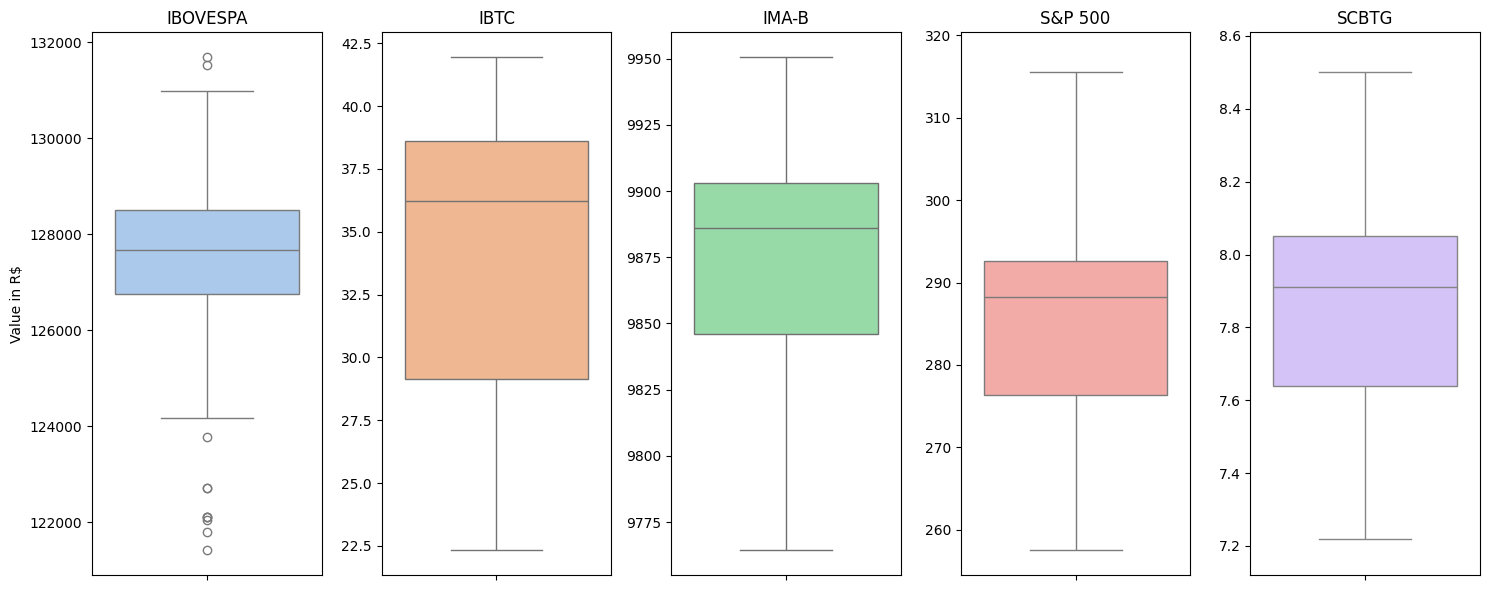

In [4]:
from matplotlib import pyplot as plt

time_series_list = []
last_length = None 

for path, name in csv_files:
    reader = CryptoCsvReader(f'data/{path}')
    data = reader.read()
    
    if last_length is not None and len(data) != last_length:
        raise Exception('lenghts not match')
    
    last_length = len(data)
    
    time_series_list.append((data, name))

time_series = [x[0] for x in time_series_list]
labels = [x[1] for x in time_series_list]

data = {
    'data': time_series,
    'label': labels  # Corresponding labels
}
df = pd.DataFrame(data)
df_exploded = df.explode('data').reset_index()
df_exploded['data'].to_markdown()
df = df_exploded
df_pivoted = df.pivot(columns='label', values='data')
df_pivoted.reset_index(drop=True, inplace=True)
df = df_pivoted
#sns.barplot(value_df, x='variable', y='value', errorbar="sd")

plt.figure(figsize=(15, 6))

# Create a boxplot for each category
for i, column in enumerate(df.columns):
    plt.subplot(1, 5, i + 1)  # Create a subplot for each boxplot
    sns.boxplot(y=df[column], color=sns.color_palette("pastel")[i])
    plt.title(column)  # Set the title for each subplot
    if i == 3:
        plt.ylim(df[column].min() - 3,df[column].max() + 4.8)
    if i == 4:
        plt.ylim(df[column].min()-0.1, df[column].max() + 0.11)
    if i == 2:
        plt.xlabel('')
    else:
        plt.xlabel('')
    if i == 0:
        plt.ylabel('Value in R$')
    else:
        plt.ylabel('')
        
# Adjust layout
#plt.xticks(range(len(labels)), labels)  # Set x-axis labels
#plt.suptitle('Boxplot of Time Series Data')
#plt.xlabel('')
#plt.text(1, 1, 'Super X-Axis Label', ha='center', fontsize=10)
#plt.text(-0.5, 0.5, 'Center of Axes', ha='center', va='center', transform=plt.gca().transAxes)
#plt.savefig('imgs/boxplot_v2.png')
plt.subplots_adjust(wspace=0.5)
plt.savefig("imgs/boxplot_v2.png", bbox_inches='tight', pad_inches=0.5)
#plt.grid(False)
plt.tight_layout()
plt.show()

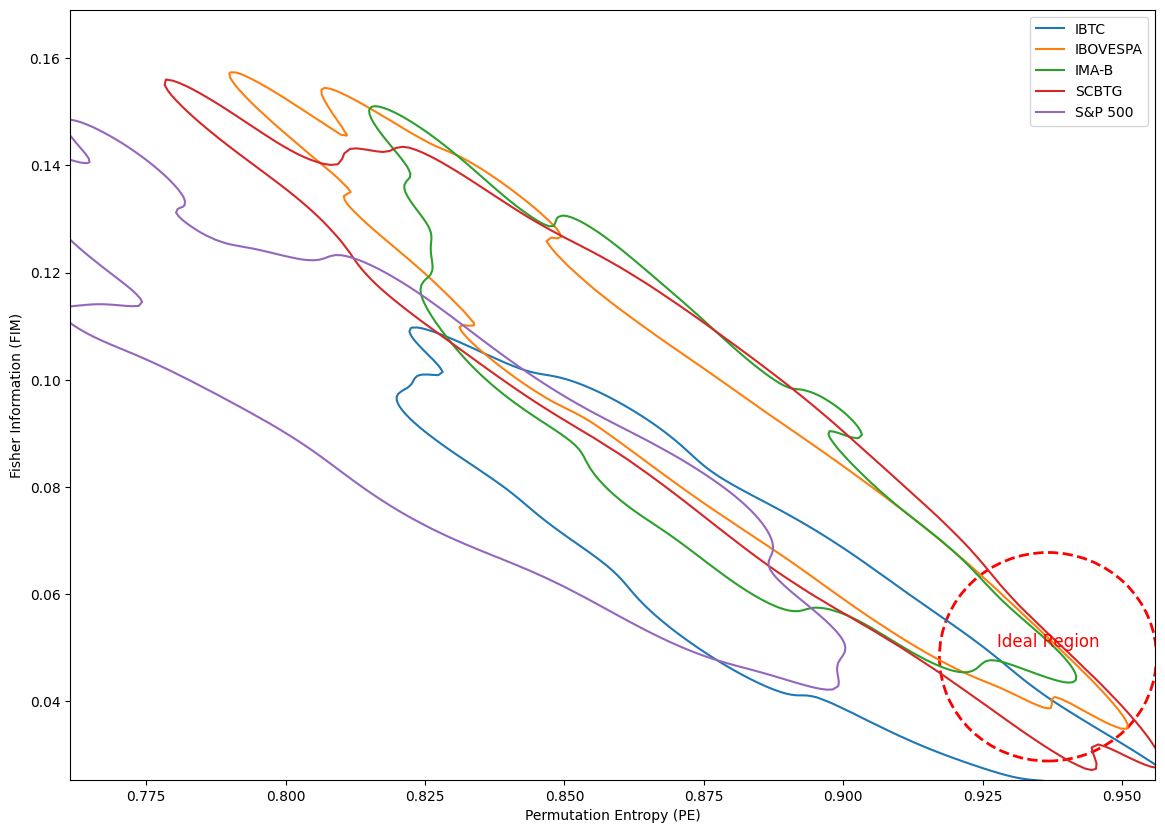

In [4]:
#why does the plot change everytime I reload the cell? must be the PCA

from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import seaborn as sns
from mfn.entropy import MFN

data = []

# Assuming df is already defined as per your code
for f, name in csv_files:
    reader = CryptoCsvReader(f'data/{f}')
    time_series = reader.read()
    value_dict = MFN(
        time_series,
        b=10,
        B=.1,
        size=100,
        dx=3
    )
    pe = value_dict['permutation entropy']
    fim = value_dict['fisher information']

    for p, f_i in zip(pe, fim):
        data.append({'PE': p, 'FIM': f_i, 'group': name})
        
df = pd.DataFrame(data)

plt.figure(figsize=(14, 10))

# Density contours with adjusted bandwidth
ax = sns.kdeplot(data=df, x='PE', y='FIM', hue='group', color='k', levels=2, bw_adjust=0.8, legend=True)

legend = ax.get_legend()
legend.set_title(None)
# Points with increased size
# sns.scatterplot(data=df, x='PE', y='FIM', hue='group', palette='viridis', alpha=0.7)

# Set axis limits to zoom in (adjust these limits as needed)
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# or
plt.xlim(df['PE'].min(), df['PE'].max())
plt.ylim(df['FIM'].min(), df['FIM'].max())

# Highlighting and labeling the ideal circular region
ideal_center_x = df['PE'].quantile(0.985)
ideal_center_y = df['FIM'].quantile(0.06)
radius = 0.1 * (df['PE'].max() - df['PE'].min())  # Adjust radius size as needed

circle = Circle(
    (ideal_center_x, ideal_center_y),
    radius,
    linewidth=2,
    edgecolor='red',
    facecolor='none',
    linestyle='--'
)
ax.add_patch(circle)

# Adding the label
plt.text(
    ideal_center_x,
    ideal_center_y + radius * 0.1,
    'Ideal Region',
    color='red',
    fontsize=12,
    ha='center'
)

plt.title('')
plt.xlabel('Permutation Entropy (PE)')
plt.ylabel('Fisher Information (FIM)')
# plt.legend(title='asset')
plt.grid(False)
plt.savefig(f'imgs/contours_mfn.png')
plt.show()


# PCA

0.9929123850584622
0.0042633862844580804


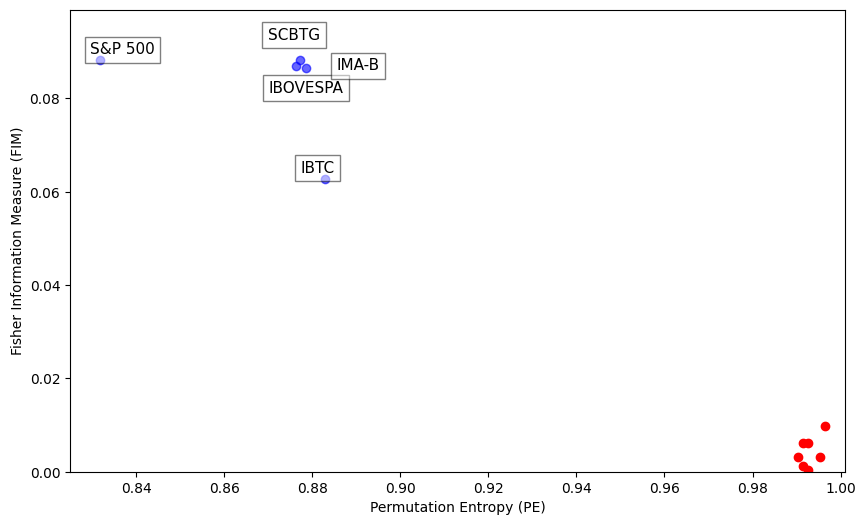

   Distance from (1,0) Asset name
0             0.132800       IBTC
1             0.148996   IBOVESPA
2             0.151117      IMA-B
3             0.151129      SCBTG
4             0.189958    S&P 500
0.8830011137692739
0.06282541969799889
IBTC


In [3]:
import matplotlib #import patches
from mfn.entropy import MFN
#import matplotlib.pyplot as plt
from math import sqrt
from adjustText import adjust_text
#matplotlib.use("WebAgg")
means = []

for f, name in csv_files:
    reader = CryptoCsvReader(f'data/{f}')
    time_series = reader.read()
    value_dict = MFN(
        time_series,
        b=10,
        B=.1,
        size=100,
        dx=3
    )
    pe = np.mean(value_dict['permutation entropy'])
    fim = np.mean(value_dict['fisher information'])
    p = (pe, fim)
    means.append((p, name))
    
x = [point[0] for point, _ in means]  # Permutation Entropy
y = [point[1] for point, _ in means]  # Fisher Information Measure
labels = [name for _, name in means]  # Labels

# Plotting the points
plt.figure(figsize=(10, 6))
# figure size 15,6 is much better to vizualize but might not fit in every format later
#plt.figure(figsize=(15, 6))

plt.scatter(x, y, color='blue', alpha=0.6)

#BEGIN IDEAL REGION
plt.xlim(0.825, 1.001)
plt.ylim(0, 0.099)
# plt.xlim(0.857, 1.001)
# plt.ylim(0, 0.095)
mean = 0.5   # Mean of the normal distribution
std_dev = 0.5  # Standard deviation of the normal distribution
# Define the interval
low_pe = 0.99
high_pe = 1
low_fim = 0   
high_fim = 0.01
# Generate random floats from the normal distribution
random_floats = np.random.normal(loc=mean, scale=std_dev, size=10000)
# Truncate the random floats to the desired interval
rf_pe = random_floats[(random_floats >= low_pe) & (random_floats <= high_pe)]
rf_fim = random_floats[(random_floats >= low_fim) & (random_floats <= high_fim)]
plt.scatter(rf_pe[:7], rf_fim[:7], color='red')
#print(f"{rf_fim[:10]} and {rf_pe[:10]}") # check if size is the same
#Highlighting and labeling the ideal circular region
# Ensure the aspect ratio is equal to maintain the shape of the circle
# Set labels and title
# Show the plot
# circle = Circle(
#     (0.92, 0.02),
#     linewidth=10,
#     edgecolor='red',
#     fill=True,
#     facecolor='none'#,
#     #linestyle='--'
# )

# # Adding the label
# plt.text(
#     ideal_center_x,
#     ideal_center_y + radius * 0.1,
#     'Ideal Region',
#     color='red',
#     fontsize=12,
#     ha='center'
# )
#END OF IDEAL REGION

# Adding labels to the points
texts = []
for i, label in enumerate(labels):
    text = plt.text(x[i], y[i], label,bbox=dict(facecolor='white', alpha=0.5), fontsize=11, ha='center')
    texts.append(text)

# Adjust the text positions to avoid overlaps
adjust_text(texts, force_text=(0.5,0.5), expand=(1.7,1.3), force_explode=(0.01,0.02))

ideal_center_x = rf_pe[:7].mean()
ideal_center_y = rf_fim[:7].mean()
radius = 0.1 * (rf_pe[:7].max() - rf_fim[:7].min())  # Adjust radius size as needed
print(f"{ideal_center_x}\n{ideal_center_y}")

# Setting the axis labels and title
plt.xlabel('Permutation Entropy (PE)')
plt.ylabel('Fisher Information Measure (FIM)')
#plt.title('Permutation Entropy vs. Fisher Information Measure')
plt.grid(False)
plt.savefig(f'imgs/means_mfn.png')
plt.show()

#Gerando Distância dos ativos .csv
dist = []
for index, (v1, v2, v3) in enumerate(zip(x, y, labels)):
    distance = sqrt(((1-v1)**2) + ((v2)**2)) # como é zero não coloquei(0-v2)
    label = v3
    dist.append((distance, label))

data = list(dist)
df = pd.DataFrame(data, columns=["Distance from (1,0)", "Asset name"])
df.to_csv('dist_asset.csv', index=False)
print(f"{df}\n{x[0]}\n{y[0]}\n{labels[0]}")


-0.7071067811865475
-0.7071067811865476
-0.7071067811865475


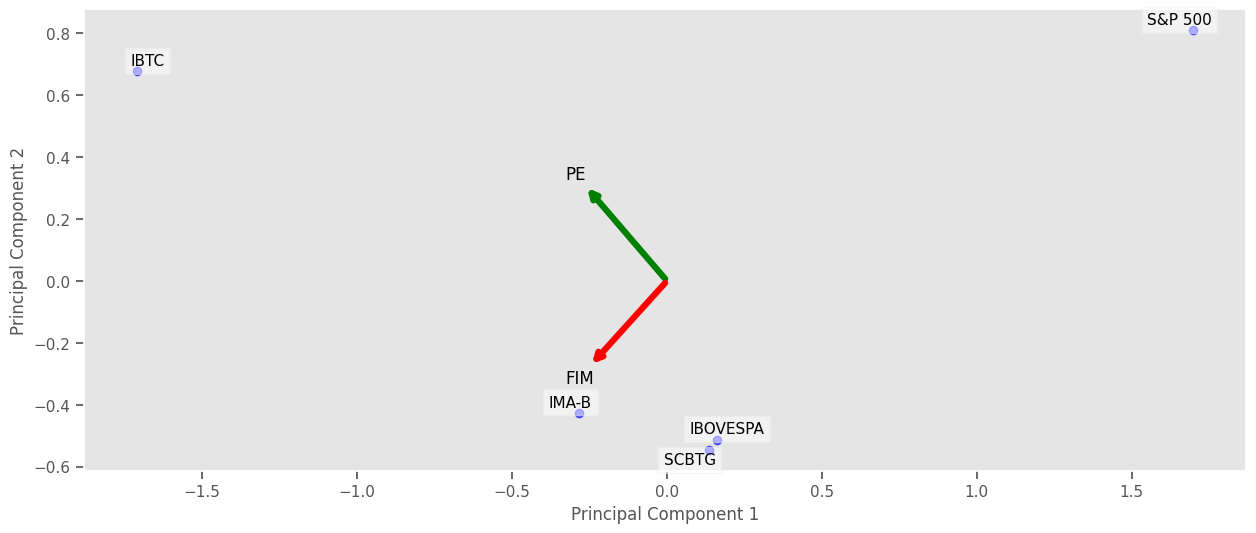

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mfn.entropy import MFN

# Assuming csv_files is a list of tuples (filename, group_name)
data = []

# Process each CSV file
for f, name in csv_files:
    reader = CryptoCsvReader(f'data/{f}')
    time_series = reader.read()
    value_dict = MFN(
        time_series,
        b=147,
        B=.147,
        size=147,
        dx=3
    )
    pe = value_dict['permutation entropy']
    fim = value_dict['fisher information']

    for p, f_i in zip(pe, fim):
        data.append({'PE': p, 'FIM': f_i, 'group': name})

# Create DataFrame from the collected data
df = pd.DataFrame(data)

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['PE', 'FIM']])

# Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a new DataFrame for PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['group'] = df['group']

# Compute the mean PC1 and PC2 for each group
mean_pca_df = pca_df.groupby('group').mean().reset_index()

# Plot the means
plt.figure(figsize=(15, 6))
#plt.figure(figsize=(10, 6)) # maybe this one will work better


plt.scatter(mean_pca_df['PC1'], mean_pca_df['PC2'], color='blue', alpha=0.6)
# Adding labels to the points
texts = []
for i, label in enumerate(mean_pca_df['group']):
    text = plt.text(mean_pca_df['PC1'][i], mean_pca_df['PC2'][i], label,bbox=dict(facecolor="white", alpha=0.5), fontsize=11, ha='center')
    texts.append(text)
adjust_text(texts, force_text=(0.5,0.5), expand=(1.2,1.3), force_explode=(0.001,0.002), expand_axes=True,min_arrow_len=7)
# Compute magnitudes of the PCA components
magnitudes = np.linalg.norm(pca.components_, axis=1)

for i, (pc1, pc2) in enumerate(pca.components_): # .annotate() doesn't mess with the scaling
    color = ['green', 'red'][i]
    plt.annotate('PE' if i == 0 else 'FIM', xy=(0, 0), xytext=(pc1/magnitudes[i] * 0.466, pc2/magnitudes[i] * 0.466),
             arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle='<-', linewidth=4.5),
                fontsize = 12)
    #plt.arrow(0, 0, pc1 / magnitudes[i] * 0.005, pc2 / magnitudes[i] * 0.005, color=color, head_length=0.08, head_width=0.08)
    #plt.text(pc1*0.1 , pc2*0.1, 'PE' if i == 0 else 'FIM', color='black', fontsize=10)

print(pc1)
print(pc2)
print(pc1/magnitudes[0])
# Setting the axis labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.title('Mean PCA Results by Group')
plt.grid(False)
plt.savefig('imgs/pca_means.png')
plt.show()


# Unnecessary Plots

In [ ]:
from matplotlib import pyplot as plt

time_series_list = []
last_length = None 

for path, name in csv_files:
    reader = CryptoCsvReader(f'data/{path}')
    data = reader.read()
    
    if last_length is not None and len(data) != last_length:
        raise Exception('lenghts not match')
    
    last_length = len(data)
    
    time_series_list.append((data, name))

time_series = [x[0] for x in time_series_list]
labels = [x[1] for x in time_series_list]

#Plots a single figure but the scale for the plots isnt the best
plt.figure(figsize=(10, 6))
sns.boxplot(data=time_series)

plt.xticks(range(len(labels)), labels)  # Set x-axis labels
plt.title('Boxplot of Time Series Data')
plt.xlabel('Asset')
plt.ylabel('Price')
plt.savefig('imgs/boxplot.png')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mfn.entropy import MFN

# Assuming csv_files is a list of tuples (filename, group_name)
data = []

# Process each CSV file
for f, name in csv_files:
    reader = CryptoCsvReader(f'data/{f}')
    time_series = reader.read()
    value_dict = MFN(
        time_series,
        b=10,
        B=.1,
        size=100,
        dx=3
    )
    pe = value_dict['permutation entropy']
    fim = value_dict['fisher information']

    for p, f_i in zip(pe, fim):
        data.append({'PE': p, 'FIM': f_i, 'group': name})

# Create DataFrame from the collected data
df = pd.DataFrame(data)

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['PE', 'FIM']])

# Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a new DataFrame for PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['group'] = df['group']

# Plot PCA results
plt.figure(figsize=(14, 10))

# Contour plot of PE and FIM
ax = sns.kdeplot(data=pca_df, x='PC1', y='PC2', hue='group', palette='viridis', levels=2, bw_adjust=0.8, legend=True)

legend = ax.get_legend()
legend.set_title(None)
# Scatter plot of PCA results
# sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='group', palette='viridis', alpha=0.7)

# Set axis limits
plt.xlim(pca_df['PC1'].min(), pca_df['PC1'].max())
plt.ylim(pca_df['PC2'].min(), pca_df['PC2'].max())

plt.title('PCA Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(False)
plt.show()


In [ ]:
## Define the start and end dates
start_date = pd.to_datetime('2020-05-1')
end_date = pd.to_datetime('2024-07-24')

date_range = pd.date_range(start=start_date, end=end_date, freq='D')

for data, name in time_series_list:
    plt.figure(figsize=(10, 6))

    # Plot the time series with the corresponding date range
    plt.plot(date_range, data, label=name, color='blue')

    # Adjust the title to be inside the plot
    plt.text(
        x=0.5,  # Horizontal position in axes coordinates (0 to 1)
        y=0.9,  # Vertical position in axes coordinates (0 to 1)
        s=f'{name}',
        fontsize=14,
        weight='bold',
        ha='center',
        transform=plt.gca().transAxes
    )

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(False)
    if name == 'EUR/USD':
        plt.savefig(f'imgs/EUR-USD_series.png')
    else:
        plt.savefig(f'imgs/{name}_series.png')
    plt.show()
 

In [ ]:
for data, name in time_series_list:
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, alpha=0.75, edgecolor='black')

    # Adjust the title to be inside the plot
    plt.text(
        x=0.7,  # Horizontal position in axes coordinates (0 to 1)
        y=0.9,  # Vertical position in axes coordinates (0 to 1)
        s=f'{name}',
        fontsize=14,
        weight='bold',
        ha='center',
        transform=plt.gca().transAxes
    )

    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.savefig(f'imgs/{name}_hist.png')
    plt.show()



# Code Examples

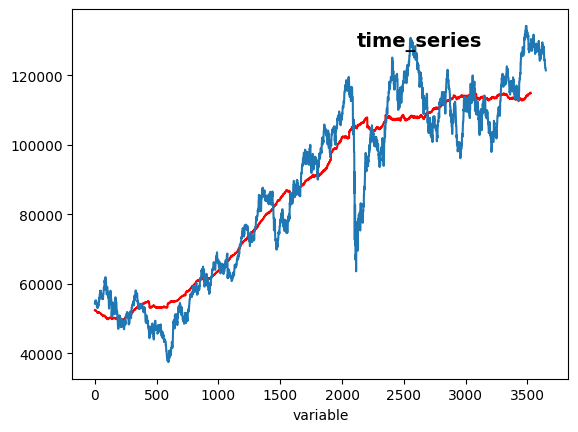

|    |   index |     0 |
|---:|--------:|------:|
|  0 |       0 | 54273 |
|  1 |       1 | 54604 |
|  2 |       2 | 55102 |
|  3 |       3 | 55102 |
|  4 |       4 | 54807 |
|      |   index |      0 |
|-----:|--------:|-------:|
| 3645 |    3645 | 122098 |
| 3646 |    3646 | 122098 |
| 3647 |    3647 | 122032 |
| 3648 |    3648 | 121802 |
| 3649 |    3649 | 121407 |
|    |   level_0 |   index |   variable |   value |
|---:|----------:|--------:|-----------:|--------:|
|  0 |         0 |       0 |          0 |   53702 |
|  1 |         1 |       1 |          0 |   51992 |
|  2 |         2 |       2 |          0 |   56928 |
|  3 |         3 |       3 |          0 |   51243 |
|  4 |         4 |       4 |          0 |   58407 |
|        |   level_0 |   index |   variable |   value |
|-------:|----------:|--------:|-----------:|--------:|
| 518611 |    518611 |     142 |       3527 |  127094 |
| 518612 |    518612 |     143 |       3527 |  107518 |
| 518613 |    518613 |     144 |       35

In [5]:
# This cell is just to test and adjust things
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mfn.bootstrap import lbb
from mfn.entropy import MFN
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy import stats as st
from utils.plotter import calculate_statistics
# Adjust the time window in utils/reader.py
# EX:
# start_date = pd.to_datetime('2024-01-11')
# end_date = pd.to_datetime('2024-06-05')
# Adjust bootstrap to fit the data correctly in every function in utils/plotter.py
# Ex: (change the b,B and size)
# lbb_samples = lbb(data, b=147, B=.147, size=147)

#change the path to your desired .csv
path = 'ibovespa.csv'
name = 'time_series'
reader = CryptoCsvReader(f'data/{path}')
data  = reader.read()
lbb_samples = lbb(data, b=147, B=.147, size=147)
lbb_df = pd.DataFrame(lbb_samples).reset_index()
lbb_df = lbb_df.melt(id_vars='index', value_vars=lbb_df.columns[1:])

# Plotting the mean of the LBB samples
lbb_df.groupby("variable").agg("mean")["value"].plot(color="red")
plt.plot(data)

# Adjust the title to be inside the plot
plt.text(
    x=0.7,  # Horizontal position in axes coordinates (0 to 1)
    y=0.9,  # Vertical position in axes coordinates (0 to 1)
    s=f"{name}",
    fontsize=14,
    weight='bold',
    ha='center',
    transform=plt.gca().transAxes
)

plt.grid(False)
plt.savefig(f'imgs/{name}_lbb_mean.png')
plt.show()
datum = pd.DataFrame(data)

#Do the indexes begin at the same place and do they also end at the same place having the same size?
print(datum.reset_index().head().to_markdown())
print(datum.reset_index().tail().to_markdown())
print(lbb_df.reset_index().head().to_markdown())
print(lbb_df.reset_index().tail().to_markdown())

In [ ]:
from matplotlib import pyplot as plt

time_series_list = []
last_length = None 

for path, name in csv_files:
    reader = CryptoCsvReader(f'data/{path}')
    data = reader.read()
    
    if last_length is not None and len(data) != last_length:
        raise Exception('lenghts not match')
    
    last_length = len(data)
    
    time_series_list.append((data, name))

group_a = ["BTC"]
#group_b = ['BNB', 'ETH','SOL','XRP','EUR/USD','NYA','Gold','S&P 500']
group_b = ['ETH','NYA']
group_c = ['Gold','S&P 500']
group_d = ['BNB','SOL','XRP','EUR/USD']

time_series = [x[0] for x in time_series_list]
labels = [x[1] for x in time_series_list]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 1 column

# First subplot: only one boxplot
axs[0,0].boxplot(time_series[0])
axs[0,0].set_title('Boxplot 1')
axs[0,0].set_ylabel('Values')
axs[0,0].set_xticklabels(group_a)

# Second subplot: two boxplots
axs[1,1].boxplot([time_series[1], time_series[3], time_series[4], time_series[5]])
axs[1,1].set_title('Boxplots 2 and 3')
axs[1,1].set_ylabel('Values')
axs[1,1].set_xticklabels(group_d)

axs[0,1].boxplot([time_series[2], time_series[6]])
axs[0,1].set_title('Boxplots 2 and 3')
axs[0,1].set_ylabel('Values')
axs[0,1].set_xticklabels(group_b)

axs[1,0].boxplot([time_series[7], time_series[8]])
axs[1,0].set_title('Boxplots 2 and 3')
axs[1,0].set_ylabel('Values')
axs[1,0].set_xticklabels(group_c)

plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
nested_array = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

# Create a figure with subplots
fig, axs = plt.subplots(1, len(nested_array), figsize=(12, 6))

# Plot each nested array as a boxplot
for i, ax in enumerate(axs):
    ax.boxplot(nested_array[i])
    ax.set_title(f'Boxplot {i+1}')

# Set common labels
plt.suptitle('Boxplots for Nested Arrays')
plt.xlabel('Values')
plt.ylabel('Arrays')
axs[0].set_xlabel("cool")
# Adjust spacing and show the plot
plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
nested_list = [[1, 2, 3], [8, 9, 1, 3], [4, 5, 6, 1]]

# Convert nested list to a DataFrame
df = pd.DataFrame({'Group': ['Group 1'] * len(nested_list[0]) + 
                   ['Group 2'] * len(nested_list[1]) + 
                   ['Group 3'] * len(nested_list[2]),
                   'Values': nested_list[0] + nested_list[1] + nested_list[2]})

# Create a box plot
sns.boxplot(x='Group', y='Values', data=df)

# Add titles
plt.title('Box Plot from Nested Lists')

# Show the plot
plt.show()

print(df)

In [ ]:
nested_list = [[1, 2, 3], [8, 9, 1, 3], [4, 5, 6, 1]]

# Create a box plot
plt.boxplot(nested_list)

# Set the x-tick labels
plt.xticks([1, 2, 3], ['Group 1', 'Group 2', 'Group 3'])

# Add titles and labels
plt.title('Box Plot from Nested Lists')
plt.xlabel('Groups')
plt.ylabel('Values')

# Show the plot
plt.show()


In [ ]:
data = {
    'team': ['A', 'A', 'A', 'A', 'B', 'B', 'B', 'B'],
    'points': [19, 12, 15, 14, 19, 23, 25, 29],
    'assists': [13, 15, 11, 8, 6, 8, 11, 14],
    'rebounds': [11, 7, 8, 12, 13, 7, 6, 8],
    'blocks': [1, 2, 2, 3, 5, 4, 3, 3]
}
df = pd.DataFrame(data)

# Step 2: Define the subplot layout (2 rows, 2 columns)
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# # Step 3: Create boxplots in each subplot
# sns.boxplot(data=df, x='team', y='points', ax=axes[0, 0])
# axes[0, 0].set_title('Points by Team')

# sns.boxplot(data=df, x='team', y='assists', ax=axes[0, 1])
# axes[0, 1].set_title('Assists by Team')

# sns.boxplot(data=df, x='team', y='rebounds', ax=axes[1, 0])
# axes[1, 0].set_title('Rebounds by Team')

# sns.boxplot(data=df, x='team', y='blocks', ax=axes[1, 1])
# axes[1, 1].set_title('Blocks by Team')

# # Step 4: Adjust layout and show the plot
# plt.tight_layout()
# plt.show()
print(df)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Creating a synthetic dataset
data = {
    'Feature1': [2.5, 2.4, 3.5, 3.6, 4.2],
    'Feature2': [2.4, 2.3, 3.2, 3.5, 4.0]
}

df = pd.DataFrame(data)
print("Original Dataset:")
print(df)

# Standardizing the data
scaler = StandardScaler()
X_std = scaler.fit_transform(df)

# Calculating the covariance matrix
cov_matrix = np.cov(X_std.T)
print("\nCovariance Matrix:")
print(cov_matrix)

# Calculating eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print("\nEigenvalues:")
print(eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)

# Sorting eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Selecting the top 2 eigenvectors
W = sorted_eigenvectors[:, :2]
print("\nSelected Eigenvectors (Principal Components):")
print(W)

# Projecting the data
X_pca = X_std.dot(W)
print("\nProjected Data (PCA Result):")
print(X_pca)

# Plotting the original data and PCA vectors
plt.figure(figsize=(12, 5))

# Original data plot
plt.subplot(1, 2, 1)
plt.scatter(df['Feature1'], df['Feature2'], color='blue')
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot PCA vectors
arrow_scale = 2
plt.arrow(0, 0, arrow_scale * W[0, 0], arrow_scale * W[1, 0], color='red', head_width=0.1, head_length=0.1)
plt.arrow(0, 0, arrow_scale * W[0, 1], arrow_scale * W[1, 1], color='green', head_width=0.1, head_length=0.1)
plt.text(arrow_scale * W[0, 0] * 1.15, arrow_scale * W[1, 0] * 1.15, 'PC1', color='red', fontsize=12)
plt.text(arrow_scale * W[0, 1] * 1.15, arrow_scale * W[1, 1] * 1.15, 'PC2', color='green', fontsize=12)
plt.grid()

# PCA-transformed data plot
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], color='red')
plt.title('PCA Transformed Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
mean = 0.5   # Mean of the normal distribution
std_dev = 0.5  # Standard deviation of the normal distribution
# Define the interval
low_pe = 0.8   # Lower bound of the interval
high_pe = 1
low_fim = 0   # Lower bound of the interval
high_fim = 0.2
# Generate random floats from the normal distribution
random_floats = np.random.normal(loc=mean, scale=std_dev, size=1000)
# Truncate the random floats to the desired interval
rf_pe = random_floats[(random_floats >= low_pe) & (random_floats <= high_pe)]
rf_fim = random_floats[(random_floats >= low_fim) & (random_floats <= high_fim)]
print(f" a {rf_pe[:10]} and then {rf_fim[:10]}")

plt.scatter(rf_pe[:10], rf_fim[:10], color='red')


In [ ]:
np.random.seed(42)  # For reproducibility
data = {
    'Category 1': np.random.normal(loc=0, scale=1, size=100),
    'Category 2': np.random.normal(loc=1, scale=1.5, size=100),
    'Category 3': np.random.normal(loc=2, scale=1, size=100),
    'Category 4': np.random.normal(loc=3, scale=0.5, size=100),
    'Category 5': np.random.normal(loc=4, scale=1.2, size=100)
}

df = pd.DataFrame(data)
plt.figure(figsize=(15, 6))

# Create a boxplot for each category
for i, column in enumerate(df.columns):
    plt.subplot(1, 5, i + 1)  # Create a subplot for each boxplot
    sns.boxplot(y=df[column], color=sns.color_palette("pastel")[i])
    plt.title(column)  # Set the title for each subplot
    plt.xlabel('')  # Optional: Remove x-label for clarity

# Adjust layout
plt.tight_layout()
plt.show()